In [73]:
import os
from sklearn.linear_model import PoissonRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import poisson
from scipy.stats import nbinom
from patsy import dmatrices
os.chdir(os.path.expanduser("~/Desktop/Classes/Research/deep_uncertainty/deep_uncertainty"))

# Bikes Data

Poisson

In [3]:
bikes = pd.read_csv('deep_uncertainty/data/bikes/hour.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'deep_uncertainty/data/bikes/hour.csv'

In [ ]:
bikes = bikes.drop(['dteday', 'instant', 'registered'], axis=1)
X = bikes.iloc[:,:-1]
X = preprocessing.StandardScaler().fit_transform(X)
mask = np.random.rand(len(bikes)) < 0.8
df_train = bikes[mask]
df_test = bikes[~mask]

expr = "cnt ~ " + " + ".join(bikes.columns[:-1])
expr

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
poisson_testing_results = sm.GLM(y_test, X_test, family=sm.families.Poisson()).fit()
# print(poisson_training_results.summary())

In [ ]:
y_preds = poisson_testing_results.mu
posterior_predictive = poisson(mu=y_preds)
np.column_stack([posterior_predictive.ppf(0.001), posterior_predictive.ppf(0.999)])[:10]

array([[ 19.,  56.],
       [ 24.,  64.],
       [ 53., 108.],
       [ 46.,  98.],
       [ 41.,  91.],
       [ 19.,  55.],
       [ 21.,  59.],
       [ 22.,  61.],
       [ 27.,  68.],
       [ 30.,  74.]])

In [ ]:
poisson_training_results.params

Intercept     3.404410
season        0.098715
yr            0.289982
mnth          0.006788
hr            0.040598
holiday       0.007363
weekday      -0.005990
workingday    0.506906
weathersit   -0.032532
temp         -0.110429
atemp         0.776292
hum          -0.321590
windspeed     0.232221
casual        0.007304
dtype: float64

In [ ]:
y_test[:10].values

array([[  1.],
       [  8.],
       [110.],
       [ 67.],
       [ 37.],
       [ 17.],
       [  6.],
       [  3.],
       [  8.],
       [ 20.]])

In [ ]:
mse = mean_squared_error(y_preds, y_test)
mse

16788.52866980368

In [ ]:
np.sqrt(mse)

129.57055479468968

In [ ]:
bikes['cnt'].mean()

189.46308763450142

In [ ]:
bikes['cnt'].std()

181.38759909186527

Negative Binomial

In [ ]:
df_train["BB_LAMBDA"] = poisson_training_results.mu
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['cnt'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, df_train).fit()
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()
nb2_predictions = nb2_training_results.get_prediction(X_test)
successes = nb2_training_results.predict(X_test, linear=True)
predictions_summary_frame = nb2_predictions.summary_frame()
predicted_counts=predictions_summary_frame['mean']

/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_48925/4066697801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["BB_LAMBDA"] = poisson_training_results.mu
/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_48925/4066697801.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['cnt'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)
/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_48925/4066697801.p

In [ ]:
nb2_training_results.params

Intercept     2.959874
season        0.122840
yr            0.335876
mnth          0.002108
hr            0.052598
holiday      -0.000544
weekday       0.007031
workingday    0.562107
weathersit   -0.044585
temp         -0.449710
atemp         0.865668
hum          -0.174929
windspeed     0.277016
casual        0.011579
dtype: float64

In [ ]:
y_preds = predicted_counts
y_test = y_test['cnt']
# n is # of successes
n = successes
# p is the probability of success
p = successes / len(y_test)
posterior_predictive = nbinom(p=p, n=n)
np.column_stack([posterior_predictive.ppf(0.001), posterior_predictive.ppf(0.999)])[:10]

array([[  273., 12773.],
       [  308., 12383.],
       [  444., 11161.],
       [  415., 11392.],
       [  405., 11473.],
       [  250., 13054.],
       [  265., 12868.],
       [  273., 12769.],
       [  302., 12451.],
       [  316., 12293.]])

In [ ]:
mse = mean_squared_error(y_preds, y_test)
mse

82832.74488982839

In [ ]:
np.sqrt(mse)

287.8067839537984

In [ ]:
y_test[:10].values

array([  1.,   8., 110.,  67.,  37.,  17.,   6.,   3.,   8.,  20.])

# Sales Data

Poisson

In [135]:
import pandas as pd

npz = np.load('/Users/braydenchristensen/Desktop/Classes/Research/code/tab-data/sales.npz')
npz.files
dataframes = {}
for key in npz.files:
    dataframes[key] = pd.DataFrame(npz[key])

X_train = dataframes['X_train']
X_val = dataframes['X_val']
X_test = dataframes['X_test']
y_train = dataframes['y_train']
y_val = dataframes['y_val']
y_test = dataframes['y_test']

print(y_train.shape)
print(X_train.shape)

(76421, 1)
(76421, 42)


In [136]:
# X = pd.concat([X_train, X_train, X_val])
# y = pd.concat([y_train, y_train, y_val])

In [137]:
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
y_train_pred = poisson_model.predict(X_train)
y_val_pred = poisson_model.predict(X_val)
y_test_preds = poisson_model.predict(X_test)

# print(poisson_model.mu)
# print(y_train_pred)

In [138]:
posterior_predictive = poisson(mu=y_test_preds)
posterior_predictive
np.column_stack([posterior_predictive.ppf(0.001), posterior_predictive.ppf(0.999)])[:10]

array([[ 0., 13.],
       [ 0., 12.],
       [ 0., 13.],
       [ 1., 17.],
       [ 1., 16.],
       [ 0.,  9.],
       [ 0., 14.],
       [ 0., 12.],
       [ 0., 13.],
       [ 2., 22.]])

In [139]:
y_test[:10].values

array([[7.],
       [5.],
       [2.],
       [3.],
       [5.],
       [2.],
       [9.],
       [1.],
       [6.],
       [4.]])

In [140]:
print(y_test_preds)
len(y_test_preds)

0       4.801078
1       4.484918
2       5.137232
3       7.226167
4       7.009805
          ...   
9548    8.416938
9549    6.311879
9550    4.751579
9551    4.190171
9552    4.615769
Length: 9553, dtype: float64


9553

In [141]:
dir(poisson_model)
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      0   No. Observations:                76421
Model:                            GLM   Df Residuals:                    76381
Model Family:                 Poisson   Df Model:                           39
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.3898e+05
Date:                Thu, 04 Apr 2024   Deviance:                   4.4394e+05
Time:                        09:27:06   Pearson chi2:                 4.84e+05
No. Iterations:                    94   Pseudo R-squ. (CS):             0.8479
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1410      0.009     15.178      0.000       0.123       0.159
1              0.7022      0.016     43.221      0.000       0.670       0.734
2              0.4583      0.013     36.332      0.000       0.434       0.483
3              0.1360      0.007     19.280      0.000       0.122       0.150
4           1.419e+05   1.11e+04     12.815      0.000     1.2e+05    1.64e+05
5              0.0340      0.014      2.487      0.013       0.007       0.061
6             -0.1698      0.008    -20.441      0.000      -0.186      -0.154
7             -0.7382      0.117     -6.308      0.000      -0.968      -0.509
8          -2.133e+05   6073.834    -35.117      0.000   -2.25e+05   -2.01e+05
9           -1.63e+05   4640.790    -35.117      0.000   -1.72e+05   -1.54e+05
10         -8.079e+04   8757.424     -9.225      0.000    -9.8e+04   -6.36e+04
11          -2.12e+04   2298.051     -9.225      0.000   -2.57e+04   -1.67e+04
12         -3.165e+05   1.08e+04    -29.222      0.000   -3.38e+05   -2.95e+05
13             0.1917      0.042      4.563      0.000       0.109       0.274
14         -2.133e+05   6073.834    -35.117      0.000   -2.25e+05   -2.01e+05
15          -2.12e+04   2298.051     -9.225      0.000   -2.57e+04   -1.67e+04
16             0.3055      0.020     15.416      0.000       0.267       0.344
17         -1.555e+05   1.21e+04    -12.815      0.000   -1.79e+05   -1.32e+05
18            -0.1819      0.004    -51.385      0.000      -0.189      -0.175
19             0.2517      0.015     17.352      0.000       0.223       0.280
20             0.1680      0.011     15.136      0.000       0.146       0.190
21            -0.2816      0.020    -14.002      0.000      -0.321      -0.242
22             0.2358      0.013     18.570      0.000       0.211       0.261
23             0.2700      0.019     14.427      0.000       0.233       0.307
24             0.3085      0.014     21.533      0.000       0.280       0.337
25          2.919e+05   6213.097     46.989      0.000     2.8e+05    3.04e+05
26          4.149e+05   8829.998     46.990      0.000    3.98e+05    4.32e+05
27          2.967e+05   1.21e+04     24.606      0.000    2.73e+05     3.2e+05
28          2.213e+05   8995.419     24.606      0.000    2.04e+05    2.39e+05
29         -6.279e+05   1.34e+04    -46.990      0.000   -6.54e+05   -6.02e+05
30         -4.556e+05   1.85e+04    -24.606      0.000   -4.92e+05   -4.19e+05
31            10.2582      0.480     21.363      0.000       9.317      11.199
32             0.2856      0.026     10.991      0.000       0.235       0.336
33             0.2315      0.006     36.894      0.000       0.219       0.244
34            -0.0084      0.005     -1.535      0.125      -0.019       0.002
35            -0.3714      0.012    -30.262      0.000      -0.395      -0.347
36

### Metrics

In [142]:
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
val_rmse = np.sqrt(mean_squared_error(y_val_pred, y_val))
rmse = np.sqrt(mean_squared_error(y_test_preds, y_test))
mae = mean_absolute_error(y_test_preds, y_test)


print(f"Train RMSE: {train_rmse}")
print(f"Val RMSE: {val_rmse}\n")
print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}\n")

from deep_uncertainty.evaluation.calibration import compute_double_poisson_nll, compute_discrete_ece

# Double Poisson NNL

y_true = np.array(y_test)
mu = np.array(y_test_preds)
phi = mu
nnl = compute_double_poisson_nll(y_true, mu, phi)
print(f"Double Poisson NNL: {nnl}")

# MP

precisions = 1 / y_test_preds
mp = np.median(precisions)
print(f"Median Precision: {mp}")

# ECE

poisson_predictions = poisson_model.get_prediction(X_test)
predictions_summary_frame = poisson_predictions.summary_frame()
lambdas = np.array(predictions_summary_frame['mean'])
from scipy.special import factorial
probs = (np.exp(-lambdas) * (lambdas ** y_test_preds)) / factorial(y_test_preds)

ece = compute_discrete_ece(np.array(y_test[0]), np.array(y_test_preds), np.array(probs))
print(f"ECE: {ece}")

Train RMSE: 8.868650403373618
Val RMSE: 8.847541013905643

Test RMSE: 7.845855102977736
Test MAE: 4.567524991652073

Double Poisson NNL: 35.251579968174994
Median Precision: 0.16286338598099723
ECE: 0.16112081345554014


In [143]:
probs = (np.exp(-lambdas) * (lambdas ** y_test_preds)) / factorial(y_test_preds)

print(np.array(probs.shape))
print(np.array(y_test_preds.shape))
print(np.array(y_test[0].shape))

[9553]
[9553]
[9553]


Negative Binomial

In [154]:
y_train = y_train.rename(columns={0: 'TARGET'})
y_test = y_test.rename(columns={0: 'TARGET'})

In [145]:
df_train = pd.concat([X_train, y_train], axis=1)

df_train["BB_LAMBDA"] = poisson_model.mu
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['TARGET'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, df_train).fit()
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

y_test_preds = nb2_training_results.predict(X_test)
y_val_preds = nb2_training_results.predict(X_val)
y_train_preds = nb2_training_results.predict(X_train)


# Count number of successful predictions
# success_threshold = 1
# test_predictions = np.array(successes)
# y_test_values = y_test.values.flatten()
# absolute_differences = np.abs(test_predictions - y_test_values)
# successful_predictions_count = np.sum(absolute_differences <= success_threshold)
# print("Number of successful predictions:", successful_predictions_count)

/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_64863/3826647845.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()


In [146]:
nb2_predictions = nb2_training_results.get_prediction(X_test)
predictions_summary_frame = nb2_predictions.summary_frame()
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test

mu = predicted_counts
variances = mu + mu**2*aux_olsr_results.params[0]
p = mu / variances
n = (mu **2 / (variances - mu)).mean() # all the values are the same
nb_pmf = nbinom(p=p, n=n)
probs = nb_pmf.pmf(y_test_preds)
print(p)

0       0.154642
1       0.166516
2       0.186277
3       0.105524
4       0.106975
          ...   
9548    0.115387
9549    0.145115
9550    0.186013
9551    0.173989
9552    0.209093
Name: mean, Length: 9553, dtype: float64


/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_64863/4279893730.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  variances = mu + mu**2*aux_olsr_results.params[0]


In [147]:
y_test[:10].values

array([[7.],
       [5.],
       [2.],
       [3.],
       [5.],
       [2.],
       [9.],
       [1.],
       [6.],
       [4.]])

In [148]:
nb2_training_results.params

0          0.078318
1          0.616434
2          0.459342
3          0.128866
4      53997.684049
5          0.047767
6         -0.177319
7         -0.697903
8    -216182.647687
9    -165176.831276
10    -62231.581565
11    -16330.239162
12   -348216.074057
13         0.168933
14   -216182.647591
15    -16330.239033
16         0.474108
17    -59198.954392
18        -0.178234
19         0.250431
20         0.144278
21        -0.240525
22         0.274878
23         0.386232
24         0.292840
25    302048.335586
26    429273.348018
27    246825.717668
28    184130.736024
29   -649620.294737
30   -379007.482015
31         6.875494
32         0.137665
33         0.253306
34        -0.003591
35        -0.342610
36         0.199030
37    107890.394259
38        -0.240082
39         1.802128
40         2.197556
41         1.847084
dtype: float64

### Metrics

In [192]:
train_rmse = np.sqrt(mean_squared_error(y_train_preds, y_train))
val_rmse = np.sqrt(mean_squared_error(y_val_preds, y_val))
rmse = np.sqrt(mean_squared_error(y_test_preds, y_test))
mae = mean_absolute_error(y_test_preds, y_test)

print(f"Train RMSE: {train_rmse}")
print(f"Val RMSE: {val_rmse}\n")
print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}")

y_true = np.array(y_test)
mu = np.array(y_test_preds)
mean = mu
alpha = aux_olsr_results.params[0]
variance = mean + mu**2 * alpha
phi = mean / variance
nnl = compute_double_poisson_nll(y_true, mu, phi)
print(f"Double Poisson NNL: {nnl}")


variances = mu + mu**2*aux_olsr_results.params[0]
precisions = 1 / variances
mp = np.median(precisions)
print(f"Median Precision: {mp}")

# TODO ECE

alpha = aux_olsr_results.params[0]
mu = y_test_preds
variances = mu + mu**2*alpha
p = mu / variances
n = (mu**2 / (variances - mu))
probs = nbinom.pmf(y_test_preds, p=p, n=n)
# print(f'probs max: {probs.max()}')
# print(f'probs min: {probs.min()}')

ece = compute_discrete_ece(np.array(y_test)[:,0], np.array(y_test_preds), np.array(probs))
print(f"ECE: {ece}")

Train RMSE: 9.255150763968368
Val RMSE: 9.283101716314107

Test RMSE: 8.262728212550202
Test MAE: 4.656295301652769


/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_64863/2737880221.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = aux_olsr_results.params[0]


Double Poisson NNL: 3.160682216653232
Median Precision: 0.022347857659916797
ECE: 0.0


/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_64863/2737880221.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  variances = mu + mu**2*aux_olsr_results.params[0]
/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_64863/2737880221.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = aux_olsr_results.params[0]


In [193]:
dict(zip(mu, variances))

{5.135012978736096: 33.20586339900626,
 4.701846526623763: 28.23658502689812,
 4.103408247345253: 22.028522511240237,
 7.962396020459563: 75.45559715538982,
 7.841661473744195: 73.3035693104739,
 2.7051819963754853: 10.495684215864953,
 5.585360104332856: 38.79581588688511,
 4.05555772474535: 21.56505404819557,
 4.198875641478885: 22.967761938639573,
 13.004985216062208: 193.05460327460796,
 6.5812304426857455: 52.69033355620696,
 8.263997543789449: 80.96708221362243,
 8.836105140569238: 91.95394130354819,
 3.8449244364554684: 19.58287210996014,
 3.0083313752365397: 12.642712558479836,
 3.826524391314679: 19.414203285098758,
 4.86496824567812: 30.061020397526878,
 4.651724983779954: 27.687378641129186,
 4.187043652152047: 22.85030149457983,
 3.905486783466708: 20.14312360976274,
 4.4389212416558985: 25.415147452391636,
 7.339614206586961: 64.68770234179303,
 3.012434585182203: 12.673115296963445,
 6.824420367392391: 56.40413464736012,
 10.573865874967534: 129.59938198183994,
 7.8608984

In [194]:
dict(zip(n, p))

{0.9393501763219604: 0.11538708928576061,
 0.9393501763219603: 0.1555905350418402,
 0.9393501763219606: 0.20909273776558446,
 0.9393501763219605: 0.17398864765731728,
 0.9393501763219607: 0.18290718560430794,
 0.9393501763219602: 0.24233027397475596}

In [ ]:
mse = mean_squared_error(y_preds, y_test)
mse

68.27267751447307

In [ ]:
np.sqrt(mse)

8.262728212550202

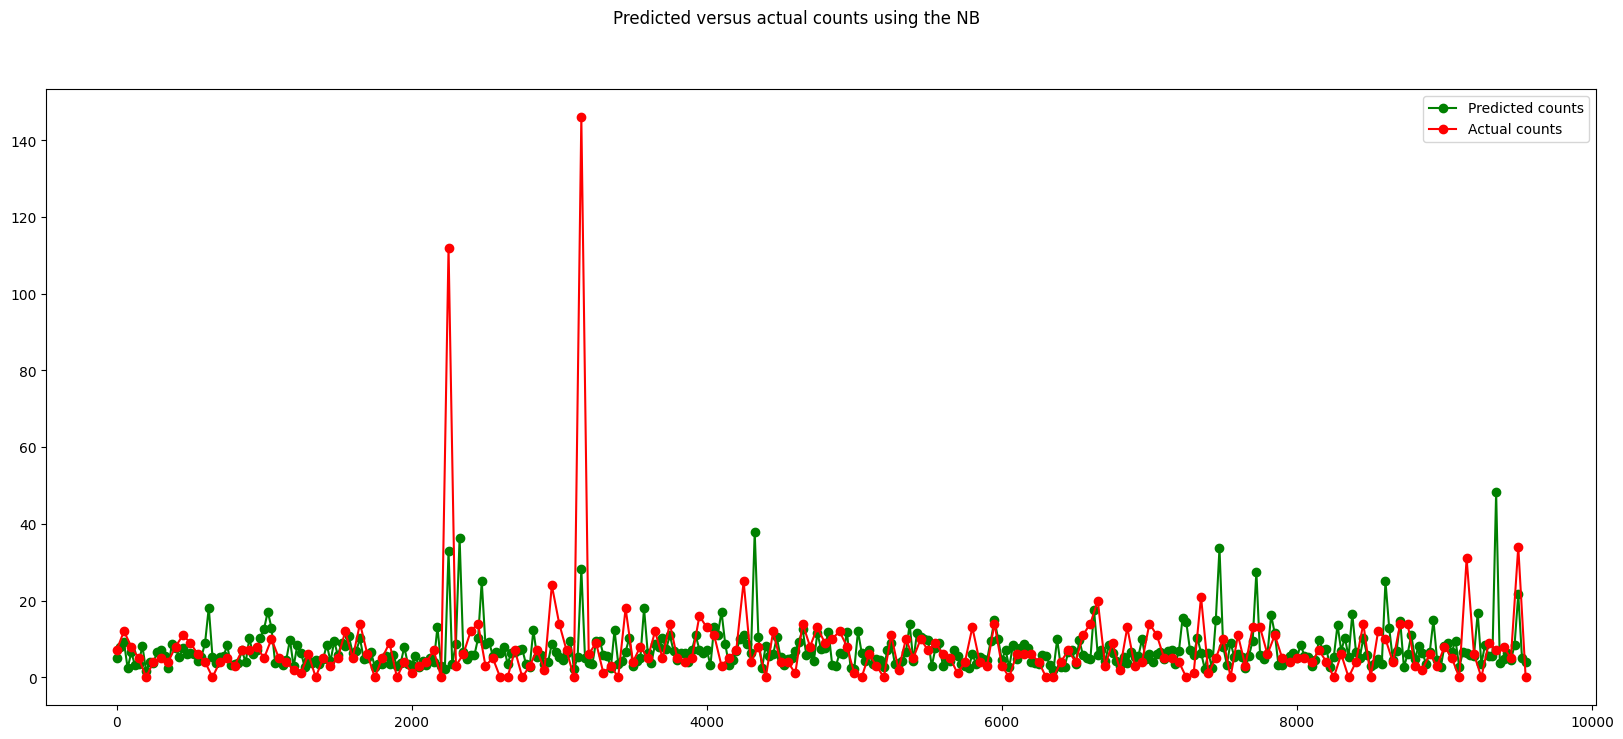

In [ ]:
import matplotlib.pyplot as plt
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test
fig = plt.figure(figsize=(20, 8))
fig.suptitle('Predicted versus actual counts using the NB')
predicted_counts1 = predicted_counts[::25]
actual1 = actual_counts[::50]
predicted, = plt.plot(predicted_counts1, 'go-', label='Predicted counts')
actual,  = plt.plot(actual1, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

# COINS dataset